In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, filtfilt
from pywt import swt, cwt
import scipy.misc
from scipy.signal import welch
import tensorflow as tf
import keras
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, AvgPool2D, Reshape, BatchNormalization, Bidirectional, LSTM
from keras.layers import Activation, GlobalMaxPool2D, SpatialDropout2D, GlobalAvgPool2D, SeparableConv1D
from keras.layers import AvgPool1D, Conv1D, GlobalMaxPool1D, MaxPool1D, SpatialDropout1D, GlobalAvgPool1D, Add, Concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler                                                      
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from scipy import signal
import pickle as pkl
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


81

In [3]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [4]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [5]:
from scipy.signal.lti_conversion import cont2discrete
const = 1e3
def cwt_EER(x):
  coef = cwt(x,np.arange(11, 31),'morl')[0]#[7:39]
  energy = np.square(coef)
  energy_each_coef_sum = sum(energy.T)
  energy_each_coef_sum_tile = np.tile(energy_each_coef_sum, (256,1)).T
  probability = np.divide(energy,energy_each_coef_sum_tile)
  entropy = -probability*np.log(probability)
  EER = np.divide(energy, entropy)
  #EER = EER/const
  return EER

In [6]:
channel = np.array([1,3,7,8,21,22,25,26,27,30])
scale = len(np.arange(11, 31))
sampling_rate = 128
window_size = 256
skip = 32
channel_len = len(channel)
classes=3
order = 6
fs = 128      # sample rate, Hz
cutoff = 60  # desired cutoff frequency of the filter, Hz
waveletname = 'db4'
bands = {'delta': [0.5/(sampling_rate/2), 4/(sampling_rate/2)], 'theta': [4/(sampling_rate/2), 8/(sampling_rate/2)], \
         'alpha': [8/(sampling_rate/2), 14/(sampling_rate/2)], 'beta': [14/(sampling_rate/2), 30/(sampling_rate/2)], \
         'gamma': [30/(sampling_rate/2), 45/(sampling_rate/2)]}

In [7]:
eeg_signal = []
valence = []
arousal = []
dominance = []
signal_freq = []
eeg_sig = []
gc.collect()

for person in range(11,12):
  print('Person No.' + str(person))
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<4] = 0
  label[(label>=4) & (label<6)] = 1
  label[(label>=6) & (label<=9)] = 2     

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label
  dom = label.T[2] # Dominance label

  del data, label
  

  for i in range(40): # Iterating through 40 vidoes/trials

    sig = eeg[i]
    sig = sig[:32, 384:]
    
    dfs = []
    for j in channel:
      ## Dividing Alpha Band
      num, den = signal.butter(4, bands['alpha'], 'bandpass')
      dfs.append(signal.filtfilt(num, den, sig[j,:]))

    sig = np.array(dfs)
    sig = sig.reshape([-1,7680])
    eeg_signal.append(sig)
  del dfs, sig, eeg
  eeg_signal = np.reshape(eeg_signal,[-1,len(channel),7680])
  gc.collect()
  for i in range(40):
    v = val[i]
    a = aro[i]
    d = dom[i]
    start = 0
    # Segmenting into 2 seconds (256 timesteps) windows with 1.75 seconds overlap
    while start + window_size <=eeg_signal.shape[2]:
      for j in range(eeg_signal.shape[1]):
        eeg_sig.append(cwt_EER(eeg_signal[i, j, start:start+window_size]))#.mean())#axis=1))
      valence.append(v)
      arousal.append(a)
      dominance.append(d)
      start += skip
#eeg_sig = np.array(eeg_sig)
gc.collect()
del eeg_signal
eeg_sig = np.reshape(eeg_sig,[-1,len(channel)*len(np.arange(11, 31)),256,1])
data = np.asarray(eeg_sig, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_sig
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)
dominance = np.asarray(dominance, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape, valence[valence==2].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape, arousal[arousal==2].shape)
print(dominance.shape, dominance[dominance == 0].shape, dominance[dominance == 1].shape, dominance[dominance==2].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
dominance = np_utils.to_categorical(dominance)

Person No.11
(9320, 200, 256, 1)
(9320,) (2563,) (3029,) (3728,)
(9320,) (4893,) (1631,) (2796,)
(9320,) (2097,) (2563,) (4660,)


# **Proposed Architecture**

In [8]:
def get_model() :
    input_shape = (data.shape[1],data.shape[2],1)
    model=Sequential()
    model.add(Conv2D(filters=16, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=32, kernel_size=(7,7), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=64, kernel_size=(9,9), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256,activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3,activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
    return model


In [9]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 128, 16)      416       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 128, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 32, 32)        25120     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 16, 32)        0

In [10]:
batch_size = 128
epochs = 30
kfold = KFold(10, True, 1)
gc.collect()

622

# **Valence**

In [11]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data,valence, test_size=0.2, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(7456, 200, 256, 1) (1864, 200, 256, 1) (7456, 3) (1864, 3)


In [12]:
foldNum=0
model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val
  gc.collect()

Results for fold 1
Epoch 1/30
53/53 [==============================] - 53s 95ms/step - loss: 1.2678 - accuracy: 0.3669 - val_loss: 1.0804 - val_accuracy: 0.4142
Epoch 2/30
53/53 [==============================] - 4s 71ms/step - loss: 1.0947 - accuracy: 0.3869 - val_loss: 1.0715 - val_accuracy: 0.4088
Epoch 3/30
53/53 [==============================] - 4s 72ms/step - loss: 1.0889 - accuracy: 0.3957 - val_loss: 1.0704 - val_accuracy: 0.4330
Epoch 4/30
53/53 [==============================] - 4s 72ms/step - loss: 1.0840 - accuracy: 0.4088 - val_loss: 1.0757 - val_accuracy: 0.4088
Epoch 5/30
53/53 [==============================] - 4s 71ms/step - loss: 1.0802 - accuracy: 0.4214 - val_loss: 1.0754 - val_accuracy: 0.4209
Epoch 6/30
53/53 [==============================] - 4s 73ms/step - loss: 1.0821 - accuracy: 0.3977 - val_loss: 1.0701 - val_accuracy: 0.4209
Epoch 7/30
53/53 [==============================] - 4s 71ms/step - loss: 1.0779 - accuracy: 0.4106 - val_loss: 1.0685 - val_accuracy: 

59/59 [==============================] - 1s 12ms/step - loss: 0.0497 - accuracy: 0.9850
Accuracy  : 0.9849785566329956
F1_Score  : 0.9846162298092024


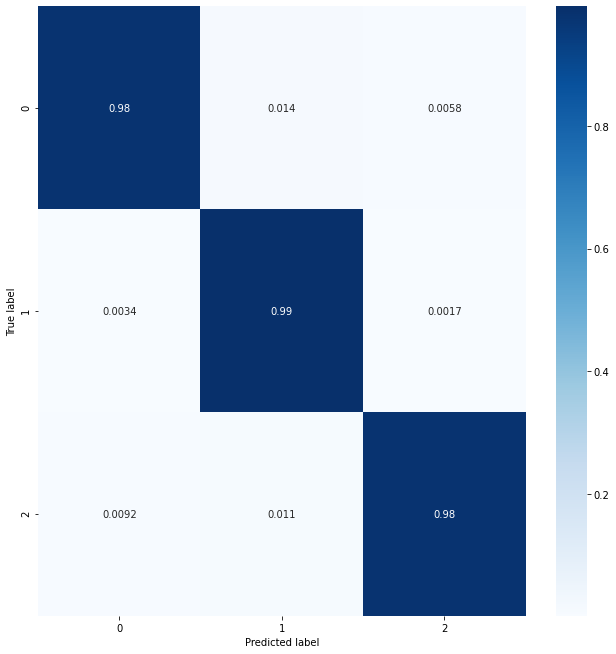

In [13]:
acrc = model.evaluate(x_test, y_test)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
c_matrix = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
c_matrix = c_matrix/np.sum(c_matrix, axis=1).reshape(3,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [14]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.2, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(7456, 200, 256, 1) (1864, 200, 256, 1) (7456, 3) (1864, 3)


In [15]:
foldNum=0
model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val
  gc.collect()

Results for fold 1
Epoch 1/30
53/53 [==============================] - 6s 83ms/step - loss: 1.1583 - accuracy: 0.4401 - val_loss: 1.0389 - val_accuracy: 0.5335
Epoch 2/30
53/53 [==============================] - 4s 74ms/step - loss: 1.0381 - accuracy: 0.5177 - val_loss: 1.0088 - val_accuracy: 0.5335
Epoch 3/30
53/53 [==============================] - 4s 71ms/step - loss: 1.0190 - accuracy: 0.5196 - val_loss: 1.0138 - val_accuracy: 0.5335
Epoch 4/30
53/53 [==============================] - 4s 70ms/step - loss: 1.0224 - accuracy: 0.5196 - val_loss: 1.0077 - val_accuracy: 0.5335
Epoch 5/30
53/53 [==============================] - 4s 70ms/step - loss: 1.0258 - accuracy: 0.5120 - val_loss: 1.0052 - val_accuracy: 0.5335
Epoch 6/30
53/53 [==============================] - 4s 73ms/step - loss: 1.0147 - accuracy: 0.5159 - val_loss: 1.0047 - val_accuracy: 0.5335
Epoch 7/30
53/53 [==============================] - 4s 73ms/step - loss: 1.0207 - accuracy: 0.5028 - val_loss: 1.0043 - val_accuracy: 0

59/59 [==============================] - 1s 10ms/step - loss: 0.0615 - accuracy: 0.9839
Accuracy  : 0.983905553817749
F1_Score  : 0.9816780109105568


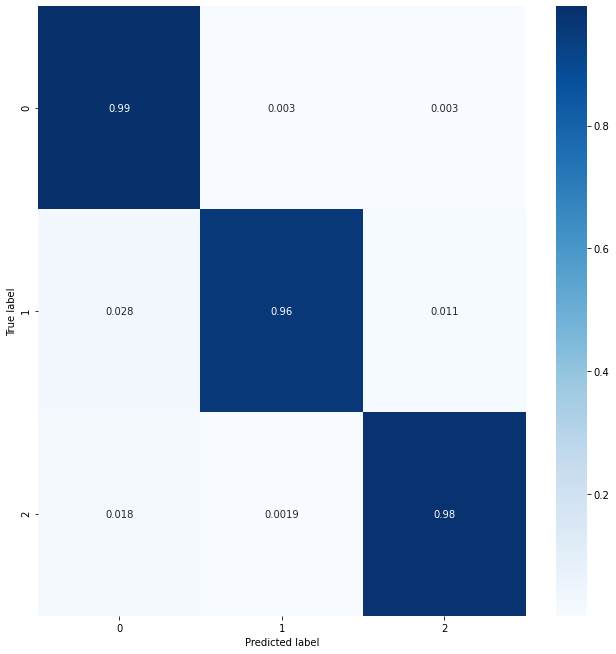

In [16]:
acrc = model.evaluate(x_test, y_test)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
c_matrix = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
c_matrix = c_matrix/np.sum(c_matrix, axis=1).reshape(3,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Dominance**

In [ ]:
'''#dominance
X_train, x_test, Y_train, y_test = train_test_split(data,dominance, test_size=0.2, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)'''

In [ ]:
'''foldNum=0
model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val
  gc.collect()'''

In [ ]:
'''acrc = model.evaluate(x_test, y_test)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
c_matrix = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
c_matrix = c_matrix/np.sum(c_matrix, axis=1).reshape(3,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()'''